# Excercise on Autoencoder of Sea level pressure data

**Goal:** Aim of this excercise is to implement an Autoencoder (AE) similar to the tutorial but this time for the sea level pressure in the North Atlantic. 


In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

plt.style.use("./../plotting.mplstyle")

## 1. Familierize yourself with the data

Sea level pressure (SLP) in the North Atlantic highly affects the climate over Europe. 

The monthly SLP data from 1950-1979 and 1979-2021 are taken from [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data are cropped over the Northern Atlantic 20°-80°N, 90°W-40°E, regridded on a $5^\circ \times 5^\circ$ resolution, detrended and then subtracted from their monthly climatology. The data can be found in ```04_vae/data/slpa_...```.



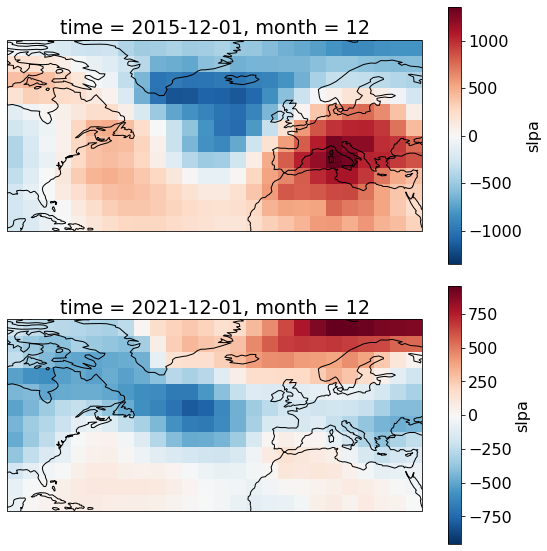

In [2]:
# Read data from file
da = xr.open_dataset("./data/slpa_1950_2021.nc")['slpa']

# Plot last year december, i.e. '2015-12'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree())
)
da.sel(time='2015-12').plot(ax=ax1, transform=ctp.crs.PlateCarree())
ax1.coastlines()
da.sel(time='2021-12').plot(ax=ax2, transform=ctp.crs.PlateCarree())
ax2.coastlines()

### The North Atlantic oscillation (NAO)

The NAO is a weather phenomenon over the North Atlantic Ocean characterized by differences in SLP between the Icelandic Low and the Azores high. The NAO can be either in positive or negative phase depending on the sign of the differences. [Wiki](https://en.wikipedia.org/wiki/North_Atlantic_oscillation)

There are different representative time-series of the NAO. One is based on pressure differences between certain points (Icelandic Low and the Azores high) [see [ClimateDataGuide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based)] and the other is based on Principal Component Analysis [see [ClimateDataGuide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based)].

***Exercise 1**: Construct the station-based NAO index, i.e. the SLP differences between Lisbon and Reykjavík.*

Hint:
- Select the location of Lisbon (lat=64, lon=21) and Reykjavik (lat=38, lon=9)
- Normalize each time-series by its standard deviation using the normalize function, $x_{norm} = \frac{x-\bar{x}}{s}$ with $\bar{x}$ is the mean and $s$ is the standard deviation (see [standard score normalization](https://en.wikipedia.org/wiki/Standard_score))

- Subtract the time-series from another 

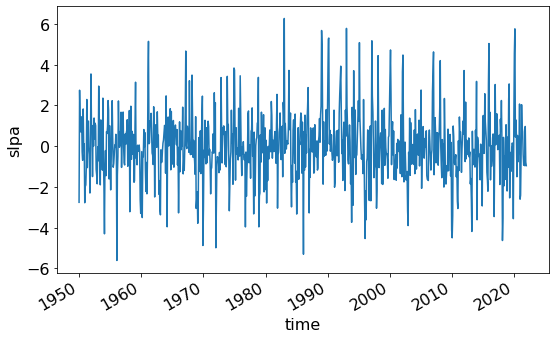

In [3]:
def normalize(da):
    """Normalize data by its standard deviation.

    x_norm = (x - mean_x)/ std_x
    
    Args:
        da (xr.DataArray): Input time-series.

    Returns:
        (xr.DataArray) Normalized time-series.
    """
    flatten = da.stack(temp=da.dims)
    mean = flatten.mean(skipna=True)
    std = flatten.std(skipna=True)
    norm_da = (flatten - mean) / std

    return norm_da.unstack('temp')


# Compute the station-based index and plot the time series
# Your Code here
# ==============
ts_rey = da.sel(lat=64, lon=21, method='nearest')
ts_rey_norm = normalize(ts_rey)

ts_lis = da.sel(lat=38, lon=9, method='nearest')
ts_lis_norm = normalize(ts_lis)

nao =  ts_lis_norm - ts_rey_norm

# Plotting
nao.plot(label='NAO (station-based)')

# ==============

## 2. Preprocess your data

As shown in the tutorial we need to define a Dataset class for training our Autoencoder. 

***Exercise 2**: Normalize the dataset in the init function.*

Hint:
- use the normalize function implemented before

In [4]:
class SLPA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.time = dataarray['time'].data
        self.lat = dataarray['lat'].data
        self.lon = dataarray['lon'].data
        
        # Normalize dataarray by standard deviation
        # Overwrite 
        self.dataarray = None
        # Your Code here
        # ===================================
        self.dataarray = normalize(dataarray)

        # ====================================
        
        # Flatten map to vector
        X = self.dataarray.data.reshape(self.dataarray.shape[0], -1)
        # Remove Nans in vector
        self.idx_nan = np.isnan(X[0,:])
        self.X = X[:, ~self.idx_nan]
        

    def __len__(self):
        """Returns the number of datapoints."""
        return len(self.dataarray)
    

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.

        Returns:
            x (torch.Tensor): Datapoint of dimension (channel, lat, lon)
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = torch.from_numpy(self.X[idx]).float()
        label = {'idx': idx}

        return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()

        # Create array with NaNs
        x_map = np.ones((len(self.lat) * len(self.lon))) * np.NaN
        # fill array with sample
        x_map[~self.idx_nan] = x

        da_map = xr.DataArray(
            data=np.reshape(x_map, (len(self.lat), len(self.lon))),
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return da_map 
        

Initialize our dataset.

In [5]:
dataset = SLPA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape[0]
print(f"Shape of datapoint: {x_dim}")

Shape of datapoint: 312


Split the data into training and validation set:

In [6]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])

# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Autoencoder

**Exercise 3:** Adapt the following Autoencoder class by using an encoder and decoder architecture with two linear layers, where the number of hidden nodes is 265.

Hints: 
- We also used a Linear encoder and decoder architecture in the tutorial
- Check out the pytorch documentation of [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)


In [7]:
class AE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        # Your Code here
        # ===============================================================================
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 265),
            nn.ReLU(),
            nn.Linear(265, z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 265),
            nn.ReLU(),
            nn.Linear(265, x_dim),
        ).to(self.device)
        
        # ===============================================================================

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        # Sum of point wise MSE
        rec_loss = torch.sum(torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        return rec_loss.mean()

Initialize AE:

In [8]:
z_dim = 2
ae = AE(x_dim, z_dim)

**Exercise 4:** How many trainable parameter does our model have now?

Hints: 
- You can calculate the number using the input dimension, number of hidden layers and z dimension
- We also used a function to print the number of training parameters in the tutorial

In [9]:
# Your Code here
# ==============
def num_of_parameters_two_layer_mlp(n_in, n_hidden, n_out):
    return n_in*n_hidden + n_hidden + n_hidden*n_out + n_out

# Solution 1
n_param_encoder = num_of_parameters_two_layer_mlp(x_dim, 256, z_dim)
n_param_decoder = num_of_parameters_two_layer_mlp(z_dim, 256, x_dim)
print("Number of trainable parameters of our model:", n_param_encoder + n_param_decoder)
    
# Solution 2
print("Number of trainable parameters of our model:",
      sum(p.numel() for p in ae.parameters() if p.requires_grad))

# ===============

Number of trainable parameters of our model: 161594
Number of trainable parameters of our model: 167264


*Note: Compared to the Linear architecture in the tutorial, CNN architecture have a much smaller number of parameters by performing equal performances on 2d data. One main reason is that they make use of the spatial correlation between neighboring points.*

### Training an NN

The training proceedure is the same es in the tutorial. We train the NN by computing the loss for each minibatch and update the gradients using backpropagation. We iterate $N$ epochs over the whole training data. No gradients are computed for the validation data.

*Optional: You can try different learning rates and epochs or even optimizers if you have time in the end.*

In [9]:
def train_epoch(model, dataloader, optimizer):
    """Train model for one epoch.

    Args:
        model (nn.Module): Model to train
        dataloader (torch.Dataloader): Dataloader of trainingsdata.
        optimizer (torch.optim): Optimizer of model parameters.

    Returns:
        mean_epoch_loss (float): training loss of one epoch
    """
    # set model into training mode
    model.train()

    epoch_loss = 0.0
    for i, data in enumerate(dataloader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        # encoding and decoding
        data, _ = data
        data = data.to(model.device)

        # loss function
        loss = model.loss(data)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss


def validate_epoch(model, dataloader):
    """Validate model for one epoch.

    Args:
        model (nn.Module): VAE model to train.
        dataloader (torch.Dataloader): Dataloader of validation data.

    Returns:
        mean_epoch_loss (float): Validation loss of one epoch.
    """
    # Set model into validation mode
    model.eval()

    epoch_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(model.device)

            # loss function
            loss = model.loss(data)
            epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss

In [10]:
# The training loop
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        ae, val_loader
    )
    train_epoch_loss = train_epoch(
        ae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 50
Train Loss: 212.7614
Val Loss: 347.4623
Epoch 2 of 50
Train Loss: 151.4651
Val Loss: 167.2644
Epoch 3 of 50
Train Loss: 145.2654
Val Loss: 157.8507
Epoch 4 of 50
Train Loss: 146.8769
Val Loss: 152.4839
Epoch 5 of 50
Train Loss: 143.0819
Val Loss: 150.7498
Epoch 6 of 50
Train Loss: 148.4828
Val Loss: 145.0089
Epoch 7 of 50
Train Loss: 152.1406
Val Loss: 143.9350
Epoch 8 of 50
Train Loss: 144.1787
Val Loss: 150.2515
Epoch 9 of 50
Train Loss: 145.6587
Val Loss: 149.8009
Epoch 10 of 50
Train Loss: 139.0831
Val Loss: 142.1988
Epoch 11 of 50
Train Loss: 138.6824
Val Loss: 141.5574
Epoch 12 of 50
Train Loss: 137.8444
Val Loss: 140.3687
Epoch 13 of 50
Train Loss: 138.0695
Val Loss: 141.1069
Epoch 14 of 50
Train Loss: 136.4918
Val Loss: 140.9606
Epoch 15 of 50
Train Loss: 136.5605
Val Loss: 138.4483
Epoch 16 of 50
Train Loss: 136.4731
Val Loss: 140.2098
Epoch 17 of 50
Train Loss: 137.3869
Val Loss: 140.8089
Epoch 18 of 50
Train Loss: 138.5225
Val Loss: 140.9417
Epoch 19 of 50
Trai

We plot the loss to see if our model learned somethin.

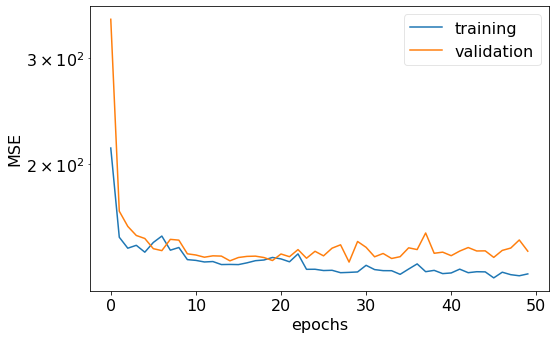

In [11]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

**Exercise 5:** Plot the input and reconstruction of the autoencoder for a qualitative comparison.

Hint:
- have a look at the tutorial

Text(0.5, 1.0, 'Reconstruction')

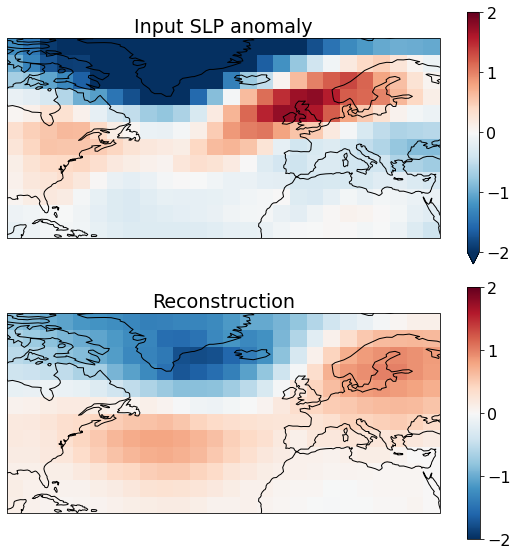

In [12]:
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# Your Code here
# ===============
# 1. encode and decode input
x_rec, z = ae.forward(x.to(ae.device))

# 2. transform flattened map back to map using get_map
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec)

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree())
)
da_in.plot(ax=ax1, transform=ctp.crs.PlateCarree(), vmin=-2, vmax=2, cmap=mpl.cm.RdBu_r)
ax1.coastlines()
ax1.set_title('Input SLP anomaly')
da_rec.plot(ax=ax2, transform=ctp.crs.PlateCarree(), vmin=-2, vmax=2, cmap=mpl.cm.RdBu_r)
ax2.coastlines()
ax2.set_title('Reconstruction')

# ==================

## Latent space

We plot the latent space and analyze which features have been compressed in the low dimensional representation.

Text(0, 0.5, '$z_2$')

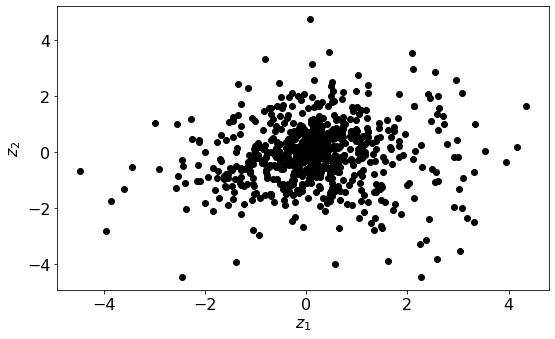

In [13]:
def encoding(model, dataloader):
    """Encoding dataset and store encoding.

    Args:
        model (nn.Module): AE model.
        dataloader (torch.Dataloader): Dataloader 

    Returns:
        encode (dict): Dictionary with encodings.
    """
    with torch.no_grad():
        encode = dict()
        for i, x in enumerate(dataloader):
            x, l = x
            out = model.forward(x.to(model.device))
            z = out[1]
            if i == 0:
                encode['z'] = z.cpu().detach().numpy()
                encode['idx'] = l['idx']
            else:
                encode['z'] = np.vstack([encode['z'], z.cpu().detach().numpy()])
                encode['idx'] = np.concatenate((encode['idx'], l['idx']))
    return encode

encode = encoding(ae, train_loader)

# Plot the encoding
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")

**Exercise 6:** Similar to the tutorial we want to see if the positive and negative phase of the NAO are seperated in the latent space. Choose the condition where the NOA index is > 2.0 for the positive phase and NOA index < -2.0 for the negative phase.

Hint:
- find the time indices where the stated conditions are valid
- plot the encoding $z$ for these time indices 

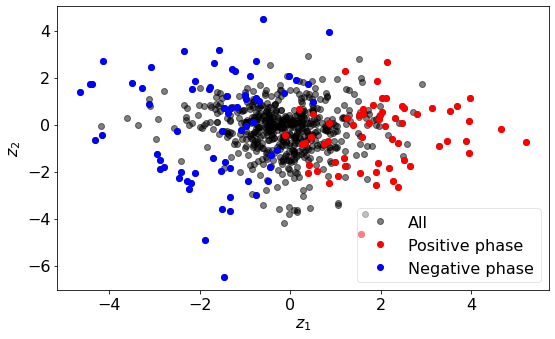

In [15]:
# Your Code here
# ==============
# get all encodings for El Nino conditions
nao_idx_pos = np.flatnonzero(np.isin(encode['idx'], np.where(nao.data > 2.0)[0]))
# get all encodings for La Nina conditions
nao_idx_neg = np.flatnonzero(np.isin(encode['idx'], np.where(nao.data < -2.0)[0]))


fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', alpha=0.5, label='All')
ax.plot(encode['z'][nao_idx_pos, 0], encode['z'][nao_idx_pos, 1], 'ro', label='Positive phase')
ax.plot(encode['z'][nao_idx_neg,0], encode['z'][nao_idx_neg,1], 'bo', label='Negative phase')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

# =================

## Latent traverse

We can traverse the latent space across different dimensions, as was shown in the tutorial.

**Optional:** You can try different traversal directions. What is a typical positive and negative NAO pattern?

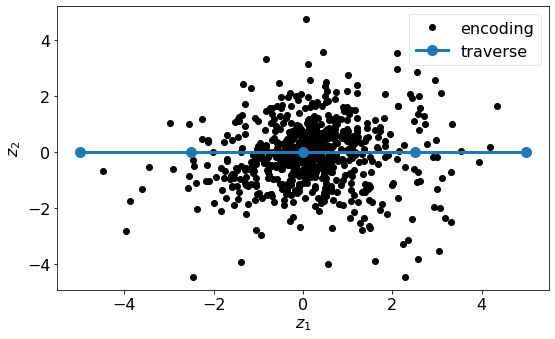

In [14]:
z_start = torch.Tensor([[0,0]])
z_eps = torch.Tensor([1,0])
z_range = torch.linspace(-5, 5, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1 ) + z_range.unsqueeze(1) * z_eps


# Plot latent space
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', label='encoding')
ax.plot(z_samples[:,0], z_samples[:,1], '-o', label='traverse', 
        markersize=10, linewidth=3)
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

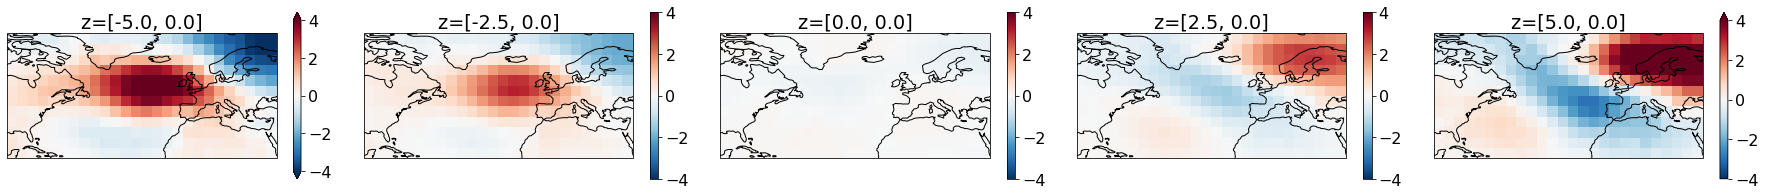

In [15]:
# Decode z
with torch.no_grad():
    traverse = ae.decoder(z_samples.to(ae.device))
    
# Plot reconstructions
fig, axs = plt.subplots(
    1, len(z_range), figsize=(len(z_range)*5, 3), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree())
)
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    da_rec.plot(ax=axs[i], transform=ctp.crs.PlateCarree(), vmin=-4, vmax=4, cmap=mpl.cm.RdBu_r)
    axs[i].coastlines()
    axs[i].set_title(f"z={z_samples[i].tolist()}")

## Comparison of AE to PCA

AE learn complex non-linear transformations to represent the data. PCA is only a linear transformation often used for dimensionality reduction. We can compare the latent spaces of both methods. 


In [16]:
from sklearn.decomposition import PCA
# Normalize and flatten data
da_norm = normalize(da)
X = da_norm.data.reshape(da_norm.shape[0], -1)

# Apply PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(X)

PCA(n_components=2)

We plot the first EOF map

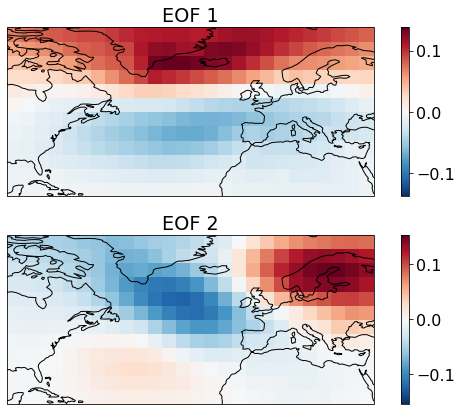

In [17]:
fig, axs = plt.subplots(
    2, 1, figsize=(8, n_components*3), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree())
)
for i in range(n_components):
    eof = xr.DataArray(
        data = pca.components_[i].reshape(da.shape[1:]),
        dims=da.dims[1:],
        coords=[da['lat'], da['lon']]
    )
    eof.plot(ax=axs[i], transform=ctp.crs.PlateCarree(),cmap=mpl.cm.RdBu_r)
    axs[i].coastlines()
    axs[i].set_title(f"EOF {i+1}")


**Exercise7:** Plot the latent space of the PCA where you color points by their NAO phase, i.e. NAO index is > 2.0 for the positive phase and NOA index < -2.0 for the negative phase. Is the latent space of PCA different to AE?

Hint:
- The latent space encoding of the PCA can be obtained by ```z = pca.transform(X)```
- Use the NAO index computed before to select the index where the conditions are true

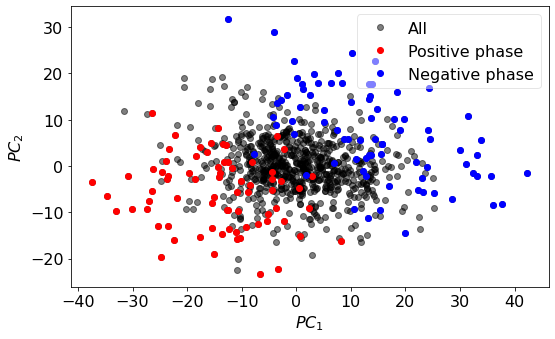

In [20]:
# Your Code here
# ==============
# 1. Get PCA latent space 
z = pca.transform(X)

# 2. Get indices where positive and negative condition holds
idx_pos = np.where(nao.data > 2.0)[0]
idx_neg = np.where(nao.data < -2.0)[0]

# 3. Plot latent space
fig, ax = plt.subplots()
ax.plot(z[:,0], z[:,1], 'ko', alpha=0.5, label='All')
ax.plot(z[idx_pos, 0], z[idx_pos, 1], 'ro', label='Positive phase')
ax.plot(z[idx_neg, 0], z[idx_neg, 1], 'bo', label='Negative phase')
ax.set_xlabel(r"$PC_1$")
ax.set_ylabel(r"$PC_2$")
ax.legend()

# ===========================